In [27]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scripts.cell_model import *
import sksundae as sun
import pandas as pd
from scripts.TXreg_funcs import *
from scripts.batch_culture_simulation import *
import joblib
from pathlib import Path
import os
import time

Defining and importing base parameters

In [28]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 20000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = 4.180555555555556e+22; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
kin = 0
M0 = 1e8 

Defining the system topology parameters

In [29]:
#choosing the product transport method. 1 indicates this method is included
lin_trans      = 1
Tp_trans       = 0
T_trans        = 0
diff_trans     = 0

#mutaually exclusive; only one of these can be 1, rest must be 0
eprodtox       = 1
elongationtox  = 0

topology = [lin_trans, Tp_trans, T_trans, diff_trans, eprodtox, elongationtox]

creating the host and engineered parameter arrays

In [30]:
base_params = [xS0, kin, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol, leaky_control=False)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
# 0     1       2       3       4         5        6        7           8
#[w0,   wT,     wE,     wEp,    wTF,    wpTox,    wTp,     k_Ep,    Km_Ep,     
#   9      10             11                 12
#  k_Tp,  Km_Tp, a_energy_pTox, a_elongation_pTox,
#   13      14      15       16       17   18    19
#  K_E,   K_pTox, kdiffP, VolCell, VolCult, ksf, ksr]

Firstly turning off the toxicity and testing the essentiality component

Setting parameters (taking optimised values)

In [41]:
xPR[[1, 2, 3, 4, 5, 13, 14]] = [9.96610284e+01, 3.15416686e+00, 1.14066975e+01, 8.04770856e-02, 3.64661063e+00, 2.12190319e-01, 2.01184874e+00]
#taking a copy for experimenting
xPR_temp = xPR.copy()
xPR_temp
xPR_temp[5] = 0
xPR_temp[13] = 20

Plotting the time series for the optimal case

Text(0, 0.5, 'External Product')

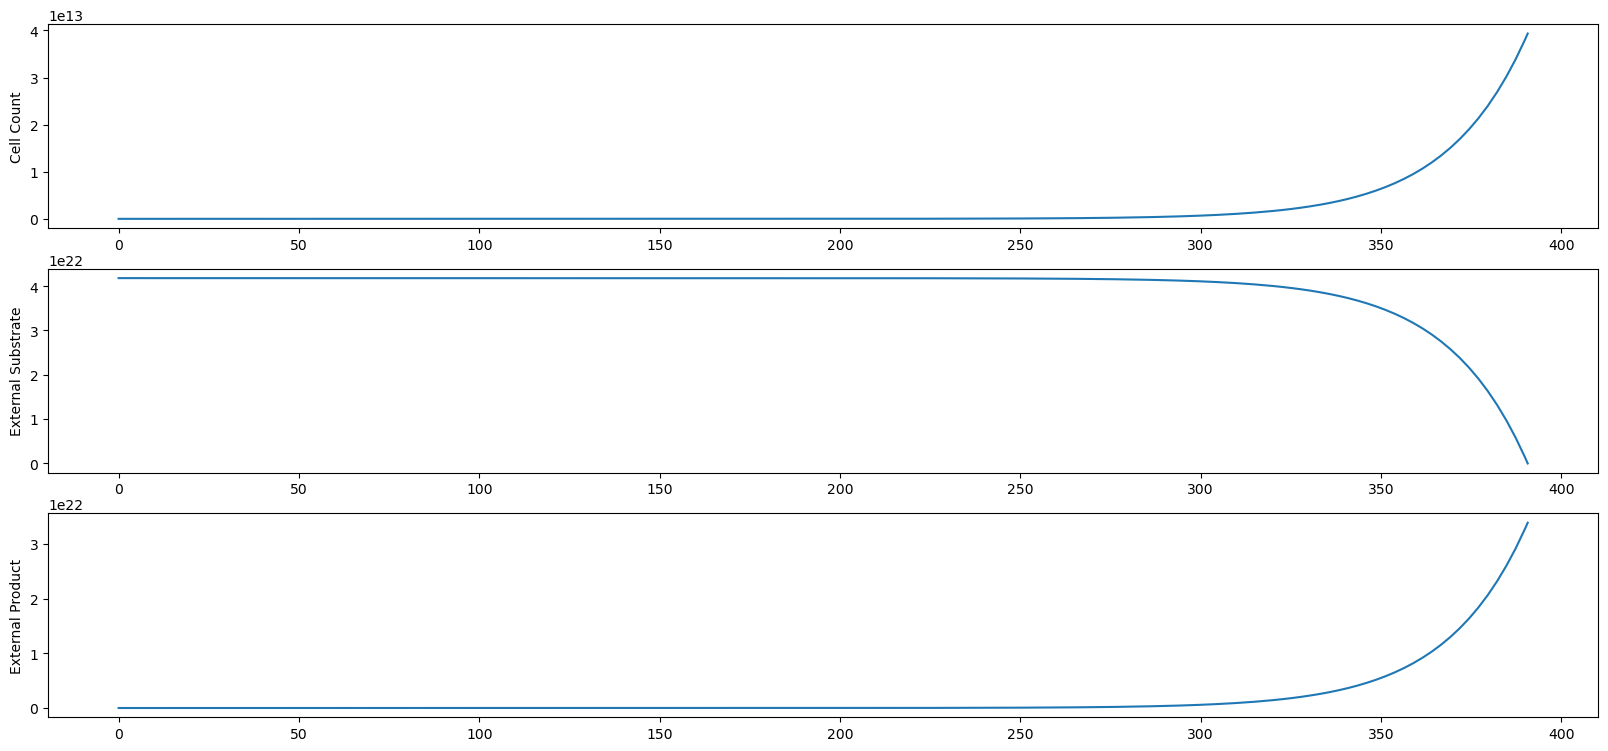

In [42]:
T_optimal, Y_optimal, vP, pY = batch_cult_sim(base_params, hPR, xPR_temp, integration_method="BDF", plot=False, rtol=1E-6, atol=1E-9)
fig, axs = plt.subplots(3, 1, figsize=(20, 9))
axs[0].plot(T_optimal, Y_optimal[0])
axs[0].set_ylabel("Cell Count")
axs[1].plot(T_optimal, Y_optimal[1])
axs[1].set_ylabel("External Substrate")
axs[2].plot(T_optimal, Y_optimal[2])
axs[2].set_ylabel("External Product")

Plotting the time series for wEp = 0.1

Text(0, 0.5, 'External Product')

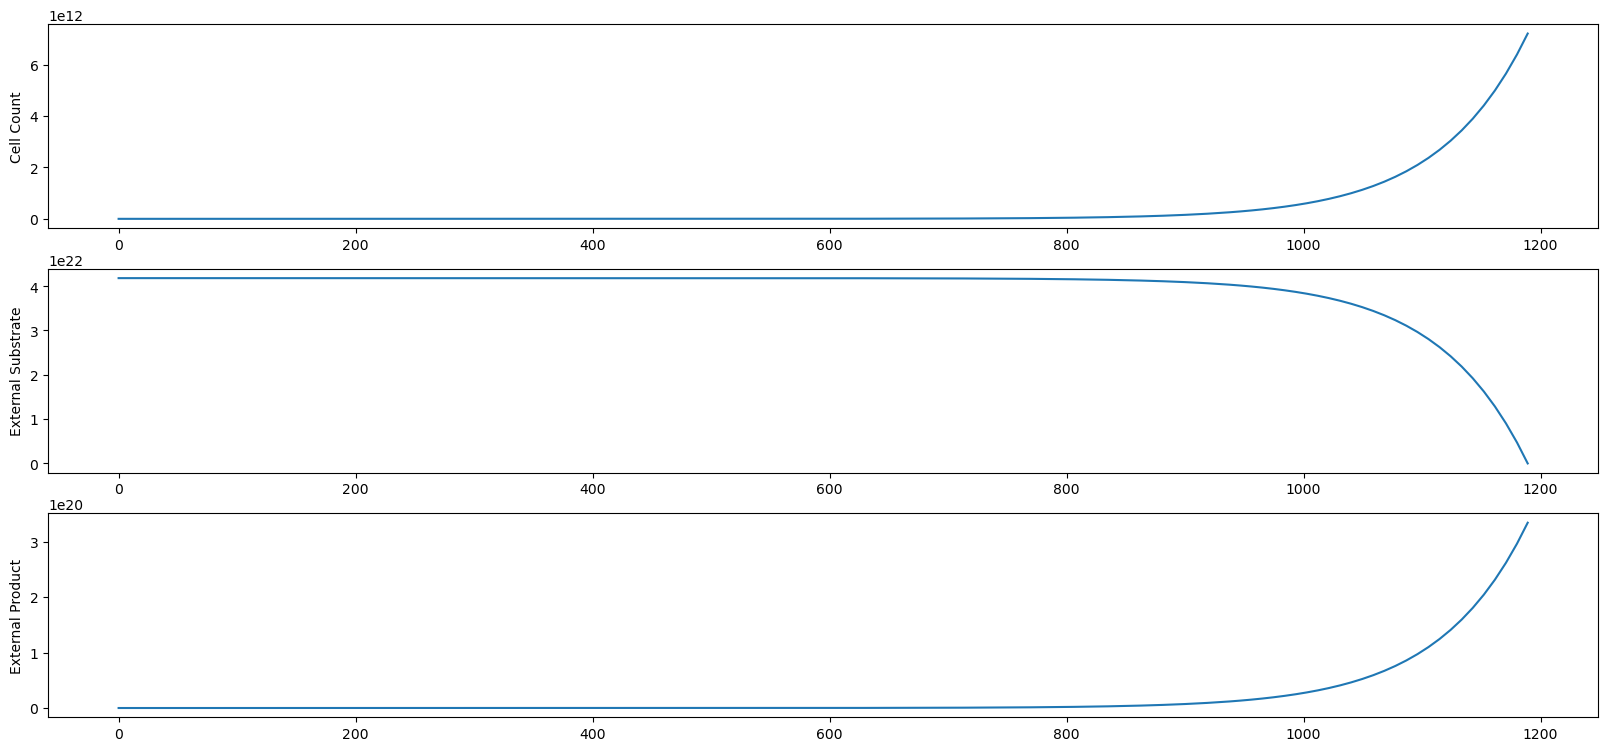

In [47]:
xPR_temp[3] = 0.1
T_mutant, Y_mutant, vP, pY = batch_cult_sim(base_params, hPR, xPR_temp, integration_method="BDF", plot=False, rtol=1E-6, atol=1E-9)
fig, axs = plt.subplots(3, 1, figsize=(20, 9))
axs[0].plot(T_mutant, Y_mutant[0])
axs[0].set_ylabel("Cell Count")
axs[1].plot(T_mutant, Y_mutant[1])
axs[1].set_ylabel("External Substrate")
axs[2].plot(T_mutant, Y_mutant[2])
axs[2].set_ylabel("External Product")

Plotting TF-P curves

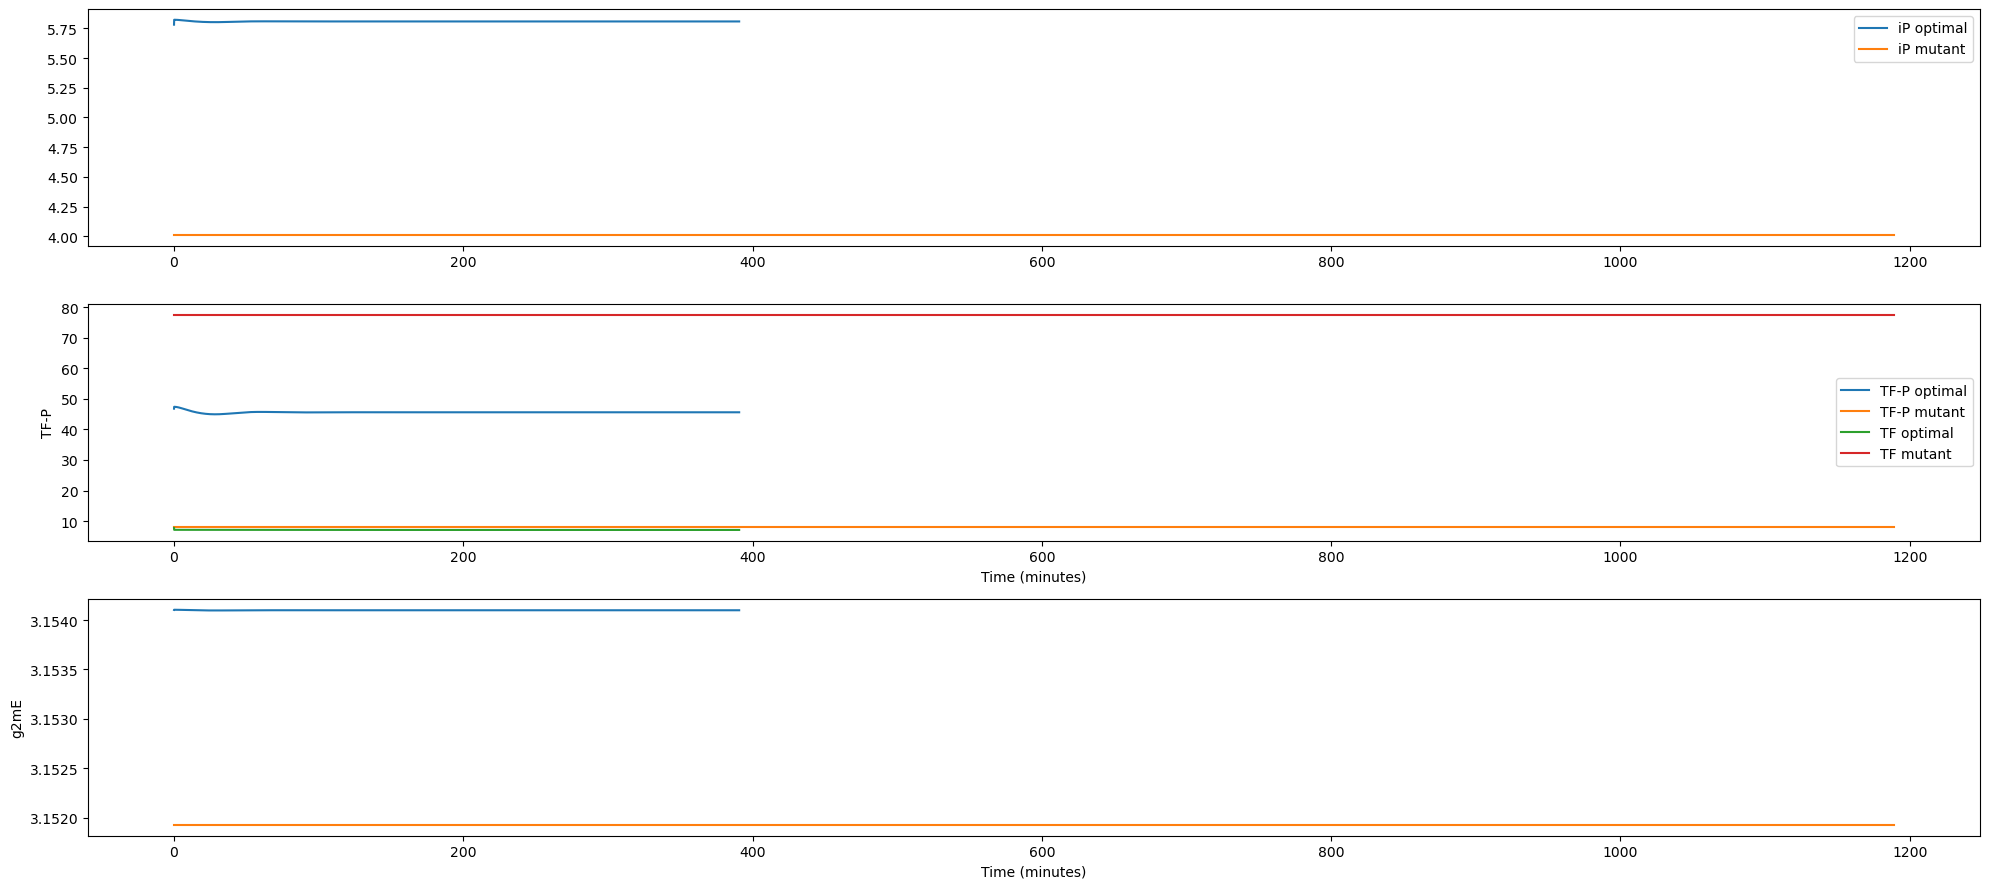

In [48]:
fig, axs = plt.subplots(3, 1, figsize=(20,9))
axs[0].plot(T_optimal, np.log10(Y_optimal[22]), label="iP optimal")
axs[0].plot(T_mutant, np.log10(Y_mutant[22]), label="iP mutant")
axs[0].legend()
axs[1].plot(T_optimal, Y_optimal[26], label="TF-P optimal")
axs[1].plot(T_mutant, Y_mutant[26], label="TF-P mutant")
axs[1].plot(T_optimal, Y_optimal[25], label="TF optimal")
axs[1].plot(T_mutant, Y_mutant[25], label="TF mutant")
axs[1].legend()
axs[1].set_ylabel("TF-P")
axs[1].set_xlabel("Time (minutes)")
axs[2].plot(T_optimal, [TXreg_ess(0, xPR[2], xPR[13], TF_P) for TF_P in Y_optimal[26]], label="optimal")
axs[2].plot(T_mutant, [TXreg_ess(0, xPR[2], xPR[13], TF_P) for TF_P in Y_mutant[26]], label="mutant")
axs[2].set_xlabel("Time (minutes)")
axs[2].set_ylabel("g2mE")
axs[0].get_xaxis().get_major_formatter().set_useOffset(False)
axs[0].get_yaxis().get_major_formatter().set_useOffset(False)
axs[2].get_xaxis().get_major_formatter().set_useOffset(False)
axs[2].get_yaxis().get_major_formatter().set_useOffset(False)
plt.tight_layout()

Calculating time series for a range of wEp

wEp range: [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 20]


C:\Users\amabe_mapds4e\AppData\Local\Temp\ipykernel_24476\615190152.py:14: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(np.log10(wEp_range), np.log10([Y[0][-1] for Y in Ys]), marker="o")


Text(0.5, 0, 'wEp')

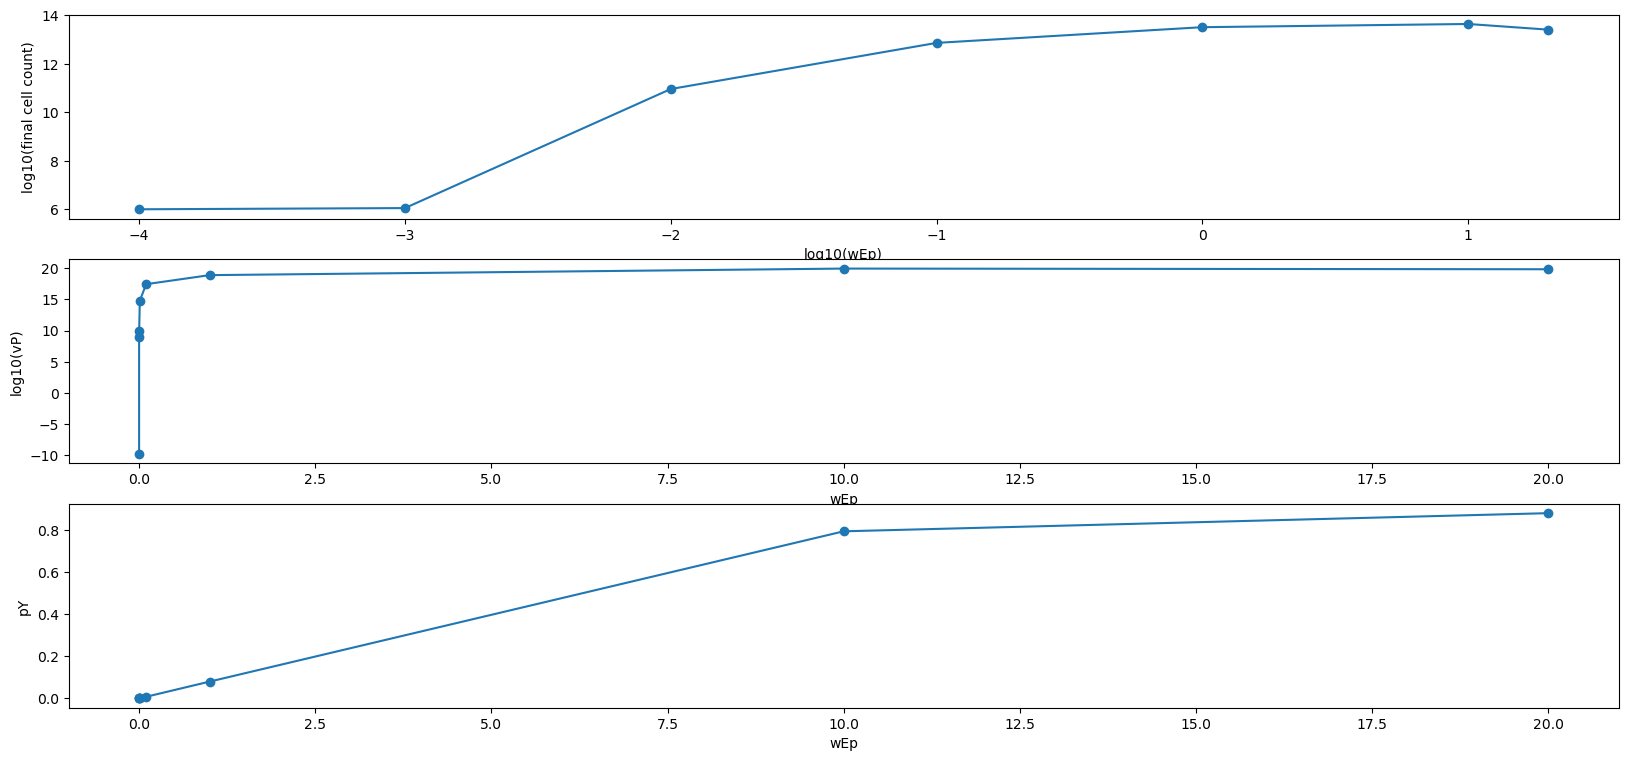

In [50]:
wEp_range = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 20]
print("wEp range: "+str(wEp_range))
Ts = []; Ys = []
vPs = []; pYs = []
for wEp_temp in wEp_range:
    xPR_temp[3] = wEp_temp
    T, Y, vP, pY = batch_cult_sim(base_params, hPR, xPR_temp, integration_method="BDF", plot=False, rtol=1E-6, atol=1E-9)
    Ts.append(T); Ys.append(Y)
    vPs.append(vP); pYs.append(pY)


#plotting final cell count, vP, pY as a function of wEp
fig, axs = plt.subplots(3, 1, figsize=(20, 9))
axs[0].plot(np.log10(wEp_range), np.log10([Y[0][-1] for Y in Ys]), marker="o")
axs[0].set_ylabel("log10(final cell count)")
axs[0].set_xlabel("log10(wEp)")
axs[1].plot(wEp_range, np.log10(vPs), marker="o")
axs[1].set_ylabel("log10(vP)")
axs[1].set_xlabel("wEp")
axs[2].plot(wEp_range, pYs, marker="o")
axs[2].set_ylabel("pY")
axs[2].set_xlabel("wEp")

Plotting the transcription rate of E as a function of TF_P no.

Text(0, 0.5, 'g2mE')

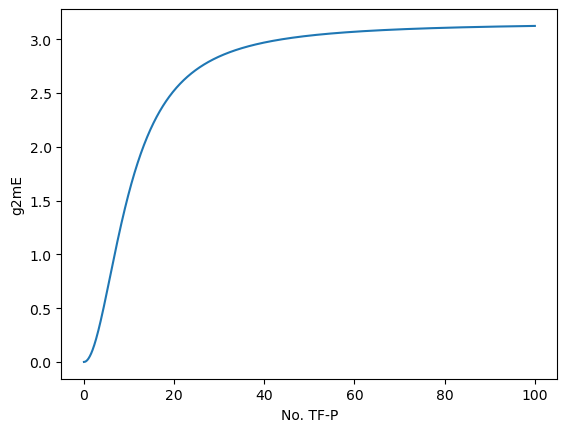

In [36]:
def TXreg_sig(eta, w0, g2m_mx, K, TF_P):
    # guard against slight negatives
    TF_P_eff = 0.0 if TF_P < 0.0 else TF_P
    term1 = g2m_mx*(1.0 - eta*eta)
    term2 = (eta*eta) * ((w0 * g2m_mx) + g2m_mx*(TF_P_eff**2)/(K**2 + TF_P_eff**2))
    return term1 + term2

TF_P_range = np.linspace(0, 100, 1000)
g2mE = [TXreg_ess(0, xPR_temp[2], 10, TF_P) for TF_P in TF_P_range]
plt.plot(TF_P_range, g2mE)
plt.xlabel("No. TF-P")
plt.ylabel("g2mE")